# Project: Face Mask Detection using PyTorch

## Overview

Comparative Study of Residual Networks and Transfer Learning for Object Detection: A Case Study on Face Mask Detection.

## Key Research Questions

* How does a manually implemented ResNet34 differ from a pretrained TorchVision model in feature extraction and convergence?
* What statistical relationships exist between dataset attributes (object sizes, masks, occlusions) and detection accuracy?
* How do strategies like fine-tuning, data augmentation, and loss reweighting affect generalization?

## Credits and Citations

* [SandhyaKrishnan02](https://www.kaggle.com/code/sandhyakrishnan02/face-mask-detection-using-pytorch/notebook)
* https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

## 1.1 Importing Libraries

In [111]:
# Installations
# Uncomment if running on Kaggle or Colab to install required packages
!pip install xmltodict # for annotations which are in xml format

In [66]:
# System & Utilities
import os
import glob
import xmltodict
import numpy as np
import pandas as pd
from pandas import json_normalize
import xmltodict

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

# TorchVision & Transforms
import torchvision
from torchvision import datasets, transforms, models

# Misc
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import random

## 1.2 Version Checks

In [67]:
print(f"PyTorch Version: {torch.__version__}")
print(f"TorchVision Version: {torchvision.__version__}")

PyTorch Version: 2.6.0+cu124
TorchVision Version: 0.21.0+cu124


## 1.2 User Variables

In [68]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/face-mask-detection
/kaggle/input/face-mask-detection/annotations
/kaggle/input/face-mask-detection/images


In [69]:
common_path = "/kaggle/input/face-mask-detection/"
xml_path = common_path + "annotations"
img_path = common_path + "images"

# 2. EDA

## 2.1 Dataset Overview and Source Audit

Summarize the file sources, dataset origins, structure, and completeness (e.g., annotation-image pair integrity, missing files).

In [70]:
total_files = []
img_files = []
xml_files = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        total_files.append(filename) # There are two types of files, .png and .xml
        if filename[-3:]=="png":
            img_files.append(filename)
        elif filename[-3:]=="xml":
            xml_files.append(filename)
        else:
            pass

print(f"Total number of files: {len(total_files)}")
print(f"Number of .img files: {len(img_files)}")
print(f"Number of .xml files: {len(xml_files)}")

Total number of files: 1706
Number of .img files: 853
Number of .xml files: 853


In [71]:
xml_files_only_names = [xml_file[:-4] for xml_file in xml_files]
img_files_only_names = [img_file[:-4] for img_file in img_files]

list(set(xml_files_only_names) - set(img_files_only_names))

[]

### Notes

* There are two types of files:
    * `.xml` files: for annotations, used to store object detection metadata
        * `xmltodict`:
            * python module to make working with xml easy, in the form of `.json`.
            * can unparse it back to `.xml` format  
    * `.png` files: for images, used for training/testing/validations
* There are no unique values present across both the `xml` and `img` lists.

## 2.2 Image Characteristics Analysis

Analyze global image characteristics such as dimensions, aspect ratios, and color depth statistics; report outliers and describe image acquisition diversity.

In [72]:
img_path = common_path+"images/"
xml_path = common_path+"annotations/"
print(f"Image Path: {img_path} \nXML Path: {xml_path}")

Image Path: /kaggle/input/face-mask-detection/images/ 
XML Path: /kaggle/input/face-mask-detection/annotations/


In [73]:
plt.imread(os.path.join(img_path, "maksssksksss737.png"))

array([[[0.3764706 , 0.8235294 , 0.5882353 , 0.5568628 ],
        [0.36862746, 0.8039216 , 0.5764706 , 0.5568628 ],
        [0.36862746, 0.79607844, 0.5803922 , 0.5568628 ],
        ...,
        [0.38039216, 0.38039216, 0.37254903, 0.5568628 ],
        [0.3764706 , 0.37254903, 0.3647059 , 0.5568628 ],
        [0.3372549 , 0.3372549 , 0.32941177, 0.5568628 ]],

       [[0.37254903, 0.8117647 , 0.5803922 , 1.        ],
        [0.37254903, 0.80784315, 0.5803922 , 1.        ],
        [0.37254903, 0.8117647 , 0.5882353 , 1.        ],
        ...,
        [0.38431373, 0.38431373, 0.3764706 , 1.        ],
        [0.38039216, 0.3764706 , 0.36862746, 1.        ],
        [0.34117648, 0.3372549 , 0.32941177, 1.        ]],

       [[0.36862746, 0.80784315, 0.5764706 , 1.        ],
        [0.36862746, 0.8039216 , 0.5764706 , 1.        ],
        [0.3764706 , 0.8156863 , 0.5882353 , 1.        ],
        ...,
        [0.38039216, 0.3764706 , 0.3764706 , 1.        ],
        [0.36862746, 0.364705

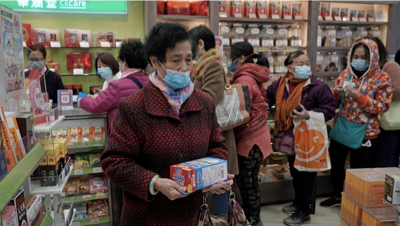

In [74]:
Image.open(os.path.join(img_path, "maksssksksss737.png"))

### Notes

* There are multiple people wearing masks. This means each image can have multiple classes classified -> multiple objects.
* Each object class is represented by a "box"

## 2.3 Annotation Quality and Structure Assessment

Evaluate annotation coverage, format consistency, bounding box completeness, and detect errors or anomalies in annotation files.

In [75]:
df_metadata = pd.DataFrame()

for xml_file in xml_files:
    xml_file_complete_path = xml_path + xml_file # z.B. /kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
    with open(xml_file_complete_path, 'r', encoding='utf-8') as file:
        metadata = xmltodict.parse(file.read())
    
    # Standardize 'object' as a list
    # If there are multiple "objects" / "people", then each image generates a list of objects
    # Such rows will produce only one column "annotation.object" using json_normalize function
    # Else, it will produce multiple columns if there are only one "object" / "person" in a single image
    
    if "object" in metadata["annotation"] and isinstance(metadata["annotation"]['object'], dict):
        metadata["annotation"]['object'] = [metadata["annotation"]['object']]
        df_t = json_normalize(metadata, record_path=None, meta=['annotation.object'])
    else:
        df_t = json_normalize(metadata)
    
    df_metadata = pd.concat([df_metadata, df_t], ignore_index=True)

In [76]:
df_metadata.head()

,annotation.folder,annotation.filename,annotation.size.width,annotation.size.height,annotation.size.depth,annotation.segmented,annotation.object
0,images,maksssksksss737.png,400,226,3,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ..."
1,images,maksssksksss410.png,400,267,3,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ..."
2,images,maksssksksss537.png,301,400,3,0,"[{'name': 'without_mask', 'pose': 'Unspecified..."
3,images,maksssksksss295.png,267,400,3,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ..."
4,images,maksssksksss771.png,400,267,3,0,"[{'name': 'with_mask', 'pose': 'Unspecified', ..."


Now, there is only one `annotation.object` column even if the row has only one image.

## 2.4 Class Label Analysis

Examine the taxonomy of target classes (e.g., "with_mask," "without_mask," "mask_weared_incorrect"), describe the annotation logic, and discuss potential ambiguities in labeling.

In [77]:
target_classes = []

for annotation_object in df_metadata["annotation.object"]:
    for i in range(len(annotation_object)):
        target_classes.append(annotation_object[i]["name"])

In [78]:
target_items = Counter(target_classes).keys()
target_values = Counter(target_classes).values()

for i,j in zip(target_items, target_values):
    print(f"{i}: {j}")

with_mask: 3232
mask_weared_incorrect: 123
without_mask: 717


### Notes:

* There are three target classes
* `with_mask`, `mask_weared_incorrect`, `without_mask`
* Should I rectify the dataset's `weared` to `worn` ? No. I don't want to f up my results for now.

## 2.5 Target Class Distribution and Imbalance Visualization

Present quantitative class frequencies, visual summaries (bar, pie charts), and compute class imbalance metrics. Discuss the implications of any observed imbalance on downstream modeling.

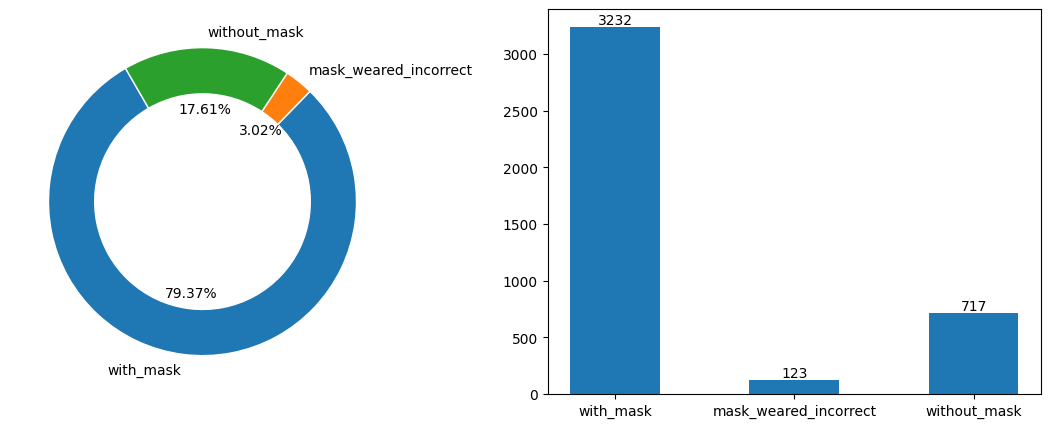

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5)) # 1 row, 2 columns, 14 inches wide, 5 inches tall

# Pie Chart
## wedgeprops=dict(width=0.3, edgecolor="w"): Draws slices as donut wedges with width 0.3 of the radius and white edges between wedges.
## radius=1: Radius of the pie chart (default is 1).
## startangle=120: Rotates the start of the pie chart by 120 degrees counterclockwise, so wedges start at that angle.
## autopct='%1.2f%%': Formats and displays the percentage value inside each wedge with 2 decimal places.

ax1.pie(target_values, 
        wedgeprops=dict(width=0.3, edgecolor="w"), 
        labels=target_items, 
        radius=1, 
        startangle=120, 
        autopct='%1.2f%%')

# Bar Chart
## width=0.5: width of the bar
## bar_label: add labels to the chart

bars = ax2.bar(target_items,
             list(target_values),
             width=0.5)
ax2.bar_label(bars) # add value to bar chart

plt.show()

### Notes

* There are three target classes
* Each class can be given a specific color to cascade the face
    * Red: without mask
    * Yellow: with mask, but worn incorrectly
    * Green: with mask

# 3. Image and Annotation Mapping

Detail the process of associating image files with their annotation files. Explain how images are parsed, and how bounding boxes and class labels are extracted from metadata.

## 3.1 Functional Utilities for Dataset Parsing

Here, consolidate all data-handling scripts, such as file listing, metadata creation, and key helper routines. Place all functions here—maintain this early in the notebook or as a separate .py file/module for import so the main workflow is streamlined.

In [80]:
def create_list_of_files(parent_dir='/kaggle/input'):
    
    img_files = []
    xml_files = []
    
    for dirname, _, filenames in os.walk(parent_dir):
        for filename in filenames:
            total_files.append(filename) # There are two types of files, .png and .xml
            if filename[-3:]=="png":
                img_files.append(filename)
            elif filename[-3:]=="xml":
                xml_files.append(filename)
            else:
                pass
                
    return img_files, xml_files

In [81]:
def create_metadata_dataframe(xml_files, img_files, common_path="/kaggle/input/face-mask-detection/"):

    xml_path = common_path + "annotations"
    img_path = common_path + "images"
    
    df_metadata = pd.DataFrame()

    for xml_file in xml_files:
        xml_file_complete_path = xml_path + xml_file # z.B. /kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
        with open(xml_file_complete_path, 'r', encoding='utf-8') as file:
            metadata = xmltodict.parse(file.read())
        
        # Standardize 'object' as a list
        # If there are multiple "objects" / "people", then each image generates a list of objects
        # Such rows will produce only one column "annotation.object" using json_normalize function
        # Else, it will produce multiple columns if there are only one "object" / "person" in a single image
        
        if "object" in metadata["annotation"] and isinstance(metadata["annotation"]['object'], dict):
            metadata["annotation"]['object'] = [metadata["annotation"]['object']]
            df_t = json_normalize(metadata, record_path=None, meta=['annotation.object'])
        else:
            df_t = json_normalize(metadata)
        
        df_metadata = pd.concat([df_metadata, df_t], ignore_index=True)

    return df_metadata

In [82]:
def face_cascade(img_name, df_metadata, common_path="/kaggle/input/face-mask-detection/"):

    img_path = os.path.join(common_path, "images")
    xml_path = os.path.join(common_path, "annotations")
    
    img = plt.imread(os.path.join(img_path, img_name))
    fig, ax = plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10, 5)
    ax.imshow(img)

    metadata_row = df_metadata[df_metadata["annotation.filename"] == img_name] # Filter metadata for just the current image
    
    if not metadata_row.empty:
        annotation_list = metadata_row.iloc[0]["annotation.object"]
        if isinstance(annotation_list, dict):
            annotation_list = [annotation_list]
        for obj in annotation_list:
            x, y, xmax, ymax = list(map(int, obj["bndbox"].values()))
            width, height = xmax - x, ymax - y
            if obj["name"] == "with_mask":
                edge_color, annotation_color, annotation_text = "g", "green", "with_mask"
            elif obj["name"] == "without_mask":
                edge_color, annotation_color, annotation_text = "r", "red", "without_mask"
            else:
                edge_color, annotation_color, annotation_text = "y", "yellow", "mask_weared_incorrect"
            mpatch = mpatches.Rectangle((x, y), width, height, linewidth=2, edgecolor=edge_color, facecolor="none")
            ax.add_patch(mpatch)
            rx, ry = mpatch.get_xy()
            ax.annotate(annotation_text, (rx, ry), color=annotation_color, weight='bold', fontsize=10, ha='left', va='baseline')


In [83]:
def create_tensor_dataset(img_files, df_metadata, common_path="/kaggle/input/face-mask-detection/"):

    img_path = os.path.join(common_path, "images")
    image_tensor = []
    label_tensor = []

    my_transform = transforms.Compose([transforms.Resize((226, 226)), transforms.ToTensor()])
    options = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}

    for img_name in img_files:
        metadata_row = df_metadata[df_metadata["annotation.filename"] == img_name]
        if not metadata_row.empty:
            annotation_list = metadata_row.iloc[0]["annotation.object"]
            if isinstance(annotation_list, dict):
                annotation_list = [annotation_list]
            for obj in annotation_list:
                xmin, ymin, xmax, ymax = list(map(int, obj["bndbox"].values()))
                width = xmax - xmin
                height = ymax - ymin
                label = options[obj["name"]]
                with Image.open(os.path.join(img_path, img_name)).convert("RGB") as im:
                    cropped_image = transforms.functional.crop(im, ymin, xmin, height, width)
                    image_tensor.append(my_transform(cropped_image))
                    label_tensor.append(torch.tensor(label))
    return image_tensor, label_tensor

### Notes

* `torchvision.transforms.Compose()`: torchvision.transforms is used for common image transformations and when Compose is chained with it to Compose several transforms together.
* `transforms.Resize()`: The default interpolation is InterpolationMode.BILINEAR. It resize the input image as per the height and width provided.
* `transforms.functional.crop()`: Crop the given image at specified location and output size and it returs torch.Tensor.

## 3.2 Visual Verification: Annotated Image Display

Present functions/cells that visualize images with bounding box overlays and class-specific color coding. This step lets you audit if parsing and mapping from annotation to image is working, and spot label errors or ambiguities.

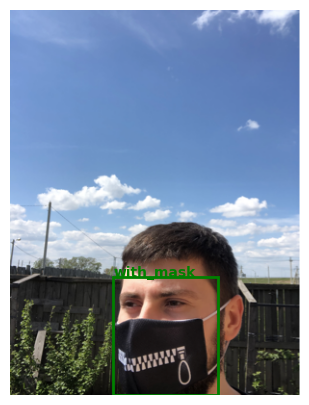

In [84]:
test_images = img_files[:1]
for img in test_images:
   face_cascade(img, df_metadata)

In [85]:
test_images = img_files[:]
test_image_tensor, test_label_tensor = create_tensor_dataset(test_images, df_metadata)

## 3.4 Dataset Preparation and Train-Test Split

Systematically generate your training, validation, and test sets, ensuring class distribution and stratification. Document the balance, random seed setting, and structure of produced datasets.

In [86]:
train_size=int(len(test_label_tensor)*0.7)
test_size=len(test_label_tensor)-train_size
print('Length of dataset is', len(test_label_tensor), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 2850 
Length of test set is : 1222


In [87]:
test_dataset = [[k,l] for k,l in zip(test_image_tensor, test_label_tensor)]

In [88]:
trainset,testset=torch.utils.data.random_split(test_dataset,[train_size, test_size])

## 3.5 DataLoader and Batch Inspection

Instantiate PyTorch DataLoader objects and visualize sample batches. Here, check both data shapes and visual samples to ensure correct batching and labelling for training.

In [89]:
train_dataloader = DataLoader(dataset=trainset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(dataset=testset, batch_size=32, shuffle=True, num_workers=4)

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [91]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


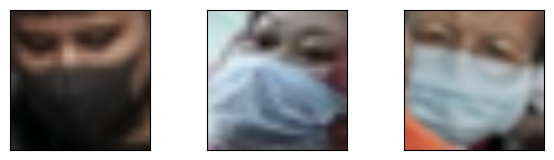

In [92]:
warnings.filterwarnings("ignore", category=UserWarning)
    
train_features_np=train_features.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(3):
    ax=fig.add_subplot(2,20//2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))

# 4. Model Development and Architecture Analysis

## 4.1 Implementation of ResNet34 Architecture

### Custom 

Present the custom-built ResNet34 class and structure, emphasizing the rationale for manual implementation (for learning, flexibility, and deeper understanding versus using built-in models).

### TorchVision

In [93]:
# TBD

In [94]:
# torchvision
model=models.resnet34(pretrained=True)

## 4.2 Feature Extraction Workflow

Detail how features are extracted at various network depths, including early convolutional layers, residual blocks, and final fully connected representations. Visualize sample feature maps or activations.

In [95]:
# TBD

In [96]:
#torchvision
for param in model.parameters():
    param.requires_grad=False

## 4.3 Model Layer Composition and Operational Details

Explain each major model component—convolutional layers, batch normalization, skip connections, linear layers—using both code and diagrams. Include basic statistics: parameter count, layer shapes, and function docstrings.

In [97]:
# TBD

In [98]:
# torchvision
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4.4 Mathematical Underpinning of Linear Transformations

Present the formulae and code for computing linear transformations, including how input dimensions relate to output for dense and convolutional operations.

In [99]:
# TBD

In [100]:
# torchvision

n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

model.fc.out_features=last_layer
print('reinitialize model with output features as 3 :', model.fc.out_features)

features_resnet34 = []
for key,value in model._modules.items():
    features_resnet34.append(value)

print(f"Features of Resnet34: {features_resnet34}")

reinitialize model with output features as 3 : Linear(in_features=512, out_features=3, bias=True)
Features of Resnet34: [Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## 4.5 Analytical Calculation of Convolutional Layer Parameters

Describe how each layer’s parameter count is derived, along with input/output dimension calculation for convolutions (formula, code example, summary table for the network).

In [101]:
# TBD

In [102]:
# torchvision

conv_param = 64 * 128 * 3 * 3
print(' Number of Parameters for conv2D is :', conv_param )

 Number of Parameters for conv2D is : 73728


## 4.6 Loss Function Selection and Evaluation

Introduce and justify your choice of loss function (e.g., Cross Entropy Loss for classification), connecting to literature. Outline the mathematics of loss computation and include a code implementation.

In [103]:
# TBD

In [104]:
# torchvision

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

## 4.7 Statistical Analysis of Loss During Training

After model-building, move to section 5 for the actual training loop. Here, closely track loss and accuracy statistics over epochs. Propose statistical measures: loss mean, variance, moving average, and convergence diagnostics (plots, AUC, overfitting check).

In [105]:
# TBD

# 5. Training and Performance Evaluation

## 5.1 Model Training Procedure

Implementing the epoch-wise training loop, define optimizers, learning rate schedule, and batch management. Record training and validation performance at each step.

In [106]:
param.requires_grad=True
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [107]:
#n_epochs=1

for epoch in range(1,2): 
    running_loss = 0.0
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % 20 == 19:    
                
                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1,running_loss/20))
        
        running_loss = 0.0
     
print('\nFinished Training')

Epoch 1, batch 20, training loss 0.4610296249389648
Epoch 1, batch 40, training loss 0.4487330913543701
Epoch 1, batch 60, training loss 0.4566064357757568
Epoch 1, batch 80, training loss 0.44390130043029785

Finished Training


## 5.2 Loss Curve Analysis and Model Convergence

Visualize training and validation loss curves, with statistical summaries. Analyze overfitting/underfitting risks, minimum loss achieved, epoch-by-epoch learning quality.

In [108]:
# TBD

## 5.3 Accuracy and Metric Evaluation

Present classification metrics—accuracy, precision, recall, F1-score—at epoch level and for final model performance. Compute confusion matrices and detailed per-class statistics.

In [109]:
# TBD

## 5.4 Checkpoints, Early Stopping, and Model Saving

Discuss strategies for saving model states (best weights, last epoch), setting early stopping thresholds based on loss plateau, and reproducibility.

In [110]:
# TBD